Import pakages !

In [1]:
import numpy as np
import pandas as pd
import talib as ta
import seaborn as sn
import matplotlib.pyplot as pt
import statsmodels.api as sm
from yahoofinancials import YahooFinancials

Extracting data !

In [2]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)
    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));

Downloading data

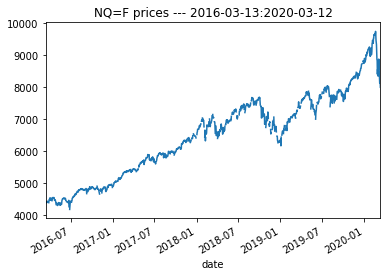

In [53]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2016-03-13', 
                  end_date='2020-03-12', 
                  freq='daily', 
                  path='D:/data/hd.csv')

Cleaning Data

In [54]:
data=pd.read_csv('D:/data/hd.csv')
data.drop(['open','high','low','dividend','split'],axis=1,inplace=True)
data.dropna(subset=['close'],inplace=True)
data.index=data.date
data.drop(['date'],axis=1,inplace=True)
#data = data[~(data == 0).any(axis=1)]
data.to_csv('D:/data/data.csv')

In [55]:
print(data)

              close       volume
date                            
2016-03-14  4366.00     156647.0
2016-03-15  4364.50     106669.0
2016-03-16  4397.50      71625.0
2016-03-17  4402.25      65619.0
2016-03-18  4414.25      51815.0
2016-03-21  4416.25     240454.0
2016-03-22  4434.50     169724.0
2016-03-23  4395.50     190219.0
2016-03-24  4397.25     212040.0
2016-03-28  4389.50     196013.0
2016-03-29  4458.25     133720.0
2016-03-30  4482.00     229527.0
2016-03-31  4476.25     222490.0
2016-04-01  4528.50     190526.0
2016-04-04  4500.25     245916.0
2016-04-05  4469.50     189635.0
2016-04-06  4535.00     218944.0
2016-04-07  4470.25     241958.0
2016-04-08  4467.25     260817.0
2016-04-11  4451.50     232565.0
2016-04-12  4490.00     243297.0
2016-04-13  4547.75     252487.0
2016-04-14  4546.25     228380.0
2016-04-15  4538.50     163850.0
2016-04-18  4546.50     171811.0
2016-04-19  4526.75     179869.0
2016-04-20  4535.75     256892.0
2016-04-21  4497.75     193071.0
2016-04-22

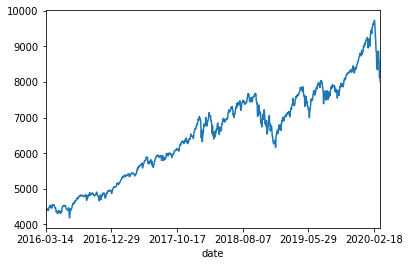

In [56]:
data['close'].plot()
pt.show()

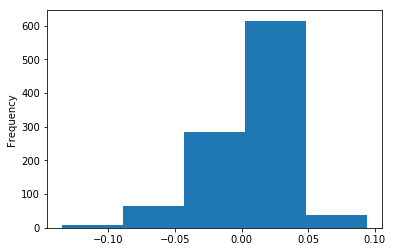

In [57]:
data['10d_close_pct']=data['close'].pct_change(10)
data['10d_close_pct'].plot.hist(bins=5)
pt.show()

In [58]:
data['10d_future_close']=data['close'].shift(-10)
data['10d_future_close_pct']=data['10d_future_close'].pct_change(10)

                         close    volume  10d_close_pct  10d_future_close  \
close                 1.000000  0.143988       0.032643          0.986543   
volume                0.143988  1.000000      -0.303419          0.055364   
10d_close_pct         0.032643 -0.303419       1.000000          0.062251   
10d_future_close      0.986543  0.055364       0.062251          1.000000   
10d_future_close_pct -0.147643 -0.198313      -0.056688          0.039838   

                      10d_future_close_pct  
close                            -0.147643  
volume                           -0.198313  
10d_close_pct                    -0.056688  
10d_future_close                  0.039838  
10d_future_close_pct              1.000000  


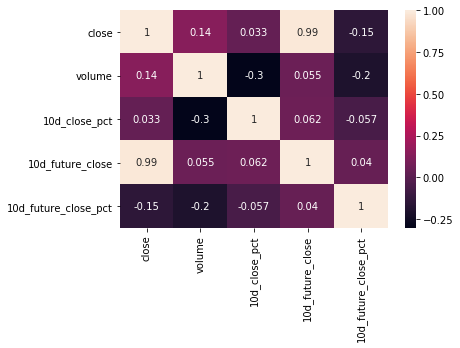

In [59]:
corr=data.corr()
print(corr)
sn.heatmap(corr,annot=True)

In [60]:
feature_names = ['10d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    data['ma' + str(n)] = ta.SMA(data['close'].values,
                              timeperiod=n) / data['close']
    # Create the RSI indicator
    data['rsi' + str(n)] = ta.RSI(data['close'].values, timeperiod=n)/data['close']
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['10d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [61]:
# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = data[feature_names]
targets = data['10d_future_close_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['10d_future_close_pct'] + feature_names
feat_targ_df = data[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                      10d_future_close_pct  10d_close_pct      ma14     rsi14  \
10d_future_close_pct              1.000000      -0.056688  0.066201 -0.003266   
10d_close_pct                    -0.056688       1.000000 -0.928218  0.499430   
ma14                              0.066201      -0.928218  1.000000 -0.534962   
rsi14                            -0.003266       0.499430 -0.534962  1.000000   
ma30                              0.082708      -0.835367  0.874561 -0.584312   
rsi30                             0.052677       0.312497 -0.335654  0.945313   
ma50                              0.070397      -0.717101  0.749769 -0.569622   
rsi50                             0.064861       0.232636 -0.250143  0.895244   
ma200                             0.174429      -0.410890  0.426815 -0.484976   
rsi200                            0.143966       0.081196 -0.093541  0.743404   

                          ma30     rsi30      ma50     rsi50     ma200  \
10d_future_close_pct  0.082708  0.

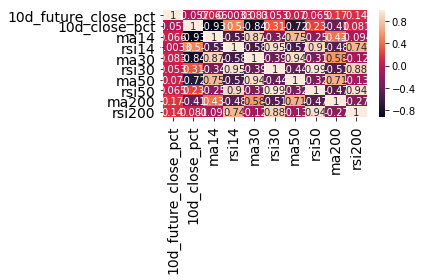

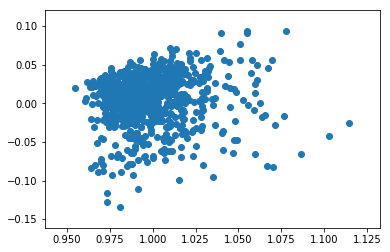

In [62]:
# Plot heatmap of correlation matrix
sn.heatmap(corr, annot=True, annot_kws = {"size": 10})
pt.yticks(rotation=0, size = 14); pt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
pt.tight_layout()  # fits plot area to the plot, "tightly"
pt.show()  # show the plot
pt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
pt.scatter(data['ma14'], data['10d_future_close_pct'])
pt.show()

In [63]:
# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
train_features=train_features.fillna(train_features.mean())
train_targets=train_targets.fillna(train_targets.mean())
print(linear_features.shape, train_features.shape, test_features.shape)

(1020, 10) (867, 10) (153, 10)


In [64]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit() # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)
# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.120
Model:                              OLS   Adj. R-squared:                  0.110
Method:                   Least Squares   F-statistic:                     12.94
Date:                  Fri, 13 Mar 2020   Prob (F-statistic):           1.71e-19
Time:                          18:37:38   Log-Likelihood:                 1911.4
No. Observations:                   867   AIC:                            -3803.
Df Residuals:                       857   BIC:                            -3755.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.3022  

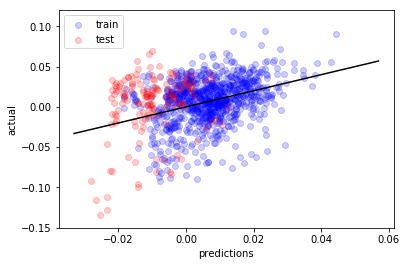

In [65]:
# Scatter the predictions vs the targets with 20% opacity
pt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
pt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = pt.xlim()
pt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
pt.xlabel('predictions')
pt.ylabel('actual')
pt.legend()  # show the legend
pt.show()